<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/LEE/CCIT_codeBert_N_N(05-19_juliet_plus).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00


In [39]:
import pandas as pd

In [40]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/model train/MSR+julite+Div_final_train(2500cut_plus_alpha).csv')

In [41]:
columns_to_drop = ['CWE ID', 'vul', 'lang']
df = df.drop(columns=columns_to_drop)

In [ ]:
df.columns

Index(['code', 'labels'], dtype='object')

In [ ]:
df = df.sort_values(by=['labels'])
df.reset_index(drop=True, inplace=True)


In [8]:
df

,code,labels
0,void func() { int data; data = 0; { #ifdef ...,7
1,void func() { int data; int dataArray[5]; d...,7
2,void func() { unsigned int data; data = 0; ...,7
3,void func() { int data; int dataArray[5]; d...,7
4,void func() { unsigned int data; data = 0; ...,7
...,...,...
10881,void func()\n{\n wchar_t * data;\n \n ...,2
10882,namespace func\n{\nfunc::func(wchar_t * dataCo...,2
10883,namespace func\n{\nfunc::func(wchar_t * dataCo...,2
10884,class func \n{\n public:\n func(cons...,2


In [42]:
import pandas as pd
import re
import gensim
import transformers
from gensim.models import Word2Vec
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from pandas.core.common import random_state
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import logging
import sklearn.metrics as metric
from transformers import DataCollatorWithPadding
import torch,gc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from transformers import RobertaForSequenceClassification, RobertaTokenizer, TrainingArguments, Trainer

In [43]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=9)
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
batch_size = 16
epoch_num = 1000
MAX_LEN = 512
learning_rate = 3.05666688133647e-05

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
import re
import pandas as pd
from datasets import Dataset
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import pandas as pd
import re

def preprocess(df, file_name):
    # 멀티 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df['code'] = df['code'].replace(re.compile(r'#include <.*?>\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include ".*?"\n'), "", regex=True)
    # 매크로 정의 제거
    df['code'] = df['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df['code'] = df['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#endif'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#indef'),"", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df['code'] = df['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df['code'] = df['code'].replace(re.compile(r'\n\s*\n'), "\n", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n'), " ", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return\s*.*?;'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return;'), "", regex=True)
    # void func로 변경
    df['code'] = df['code'].replace(re.compile(r'\b([a-zA-Z_]\w*)\s+([a-zA-Z_]\w*)\s*\(.*?\)\s*{'), r"void func() {", regex=True)
    # 중복된 code 내용 제거
    df = df.drop_duplicates(subset=['code'])

    # 데이터프레임을 CSV 파일로 저장
    df.to_csv(file_name, index=False)
    return df  # 수정된 데이터프레임 반환

# 데이터셋을 Pandas DataFrame으로 변환
df = pd.DataFrame(df)

# 오버샘플링 적용
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df.drop(columns=['labels']), df['labels'])

# 오버샘플링 후 클래스 분포 확인
print(f"Resampled dataset shape: {Counter(y_res)}")

# 오버샘플링된 데이터를 다시 Dataset 객체로 변환
resampled_df = pd.concat([X_res, y_res], axis=1)
resampled_dataset = Dataset.from_pandas(resampled_df)

def tokenized(examples):
  return tokenizer(examples['code'], pad_to_max_length=True, max_length=MAX_LEN,truncation=True, return_token_type_ids=True)

Resampled dataset shape: Counter({7: 2126, 5: 2126, 8: 2126, 1: 2126, 6: 2126, 0: 2126, 4: 2126, 2: 2126, 3: 2126})


In [45]:
preprocess(df,"preprocess.csv")
dataset = load_dataset("csv",data_files="preprocess.csv")['train']
encoded_dataset = resampled_dataset.map(tokenized,remove_columns=['code'],batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/19134 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [46]:
encoded_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 19134
})

In [47]:
encoded_dataset = encoded_dataset.train_test_split(0.3,seed=11)

In [ ]:
# 레이블 값 출력 확인
print(encoded_dataset['train']['labels'])
print(encoded_dataset['test']['labels'])


KeyError: "Column train not in the dataset. Current columns in the dataset: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']"

In [48]:
optimizer = torch.optim.AdamW(model.parameters(),
            lr = learning_rate, betas=(0.9,0.99), eps=1e-8,
            weight_decay=0.1)
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer,
                                        num_warmup_steps=5, num_training_steps=5)
optimizers = optimizer, scheduler


In [49]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [31]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=9)



In [32]:
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 10),
        "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
    }


In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # 각 클래스에 대한 F1 스코어 계산
    f1_per_class = f1_score(labels, predictions, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

    # 가중 평균, 매크로 평균, 마이크로 평균 F1 스코어 계산
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    # 결과를 딕셔너리 형태로 저장
    metrics = {
        'accuracy': accuracy,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }

    # 클래스별 F1 스코어를 딕셔너리에 추가
    for i, f1 in enumerate(f1_per_class):
        metrics[f'f1_class_{i}'] = f1

    return metrics

In [51]:
from transformers import TrainerCallback
class CustomTrainerCallback(TrainerCallback):
    def __init__(self, trainer, eval_dataset, early_stopping_patience=5):
        self.trainer = trainer
        self.eval_dataset = eval_dataset
        self.early_stopping_patience = early_stopping_patience
        self.best_loss = float('inf')
        self.patience_counter = 0
        self.incorrect_samples = []

    def on_evaluate(self, args, state, control, **kwargs):
        eval_loss = kwargs.get('metrics', {}).get('eval_loss')

        if eval_loss is not None:
            if eval_loss < self.best_loss:
                self.best_loss = eval_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.early_stopping_patience:
                print(f"No improvement in {self.early_stopping_patience} evaluation steps. Stopping training early.")
                control.should_training_stop = True

        # Evaluate를 위한 DataLoader 설정 및 평가 로직
        eval_dataloader = self.trainer.get_eval_dataloader(self.eval_dataset)
        self.trainer.model.eval()
        for batch in eval_dataloader:
            batch = {k: v.to(self.trainer.args.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = self.trainer.model(**batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                labels = batch['labels']
                incorrect_mask = predictions != labels

            if incorrect_mask.any():
                incorrect_samples = {k: v[incorrect_mask].cpu().numpy() for k, v in batch.items()}
                self.incorrect_samples.append(incorrect_samples)

        print("Collected incorrect predictions for further analysis.")

In [53]:
# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1000,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='loss'
)

# 트레이너 초기화 및 사용자 정의 콜백 추가

# 콜백 인스턴스 생성 및 트레이너 초기화

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics
)

In [55]:
callback = CustomTrainerCallback(trainer, encoded_dataset['test'], 5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
    callbacks=[callback]
)


In [27]:
!pip install optuna
!pip install transformers
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install shap
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00


In [37]:
# Optuna와 트레이너 통합
best_run = trainer.hyperparameter_search(direction="maximize", n_trials=9, hp_space=hp_space)

[I 2024-05-19 08:19:23,347] A new study created in memory with name: no-name-59d9eb71-e28a-4312-bc27-933f41901456
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
1,1.797000,1.023941,0.661731,0.661731,0.657104,0.655761,0.661731,0.471392,0.418314,0.941980,0.623656,0.730491,0.687127,0.699918,0.660282,0.668689
2,0.687800,0.595159,0.816060,0.816060,0.815077,0.813698,0.816060,0.626838,0.718725,0.963636,0.770132,0.830575,0.833470,0.885542,0.819359,0.875000
3,0.329500,0.490032,0.877373,0.877373,0.875896,0.875011,0.877373,0.713165,0.818107,0.975450,0.869020,0.870918,0.877276,0.892504,0.929985,0.928678
4,0.179800,0.485545,0.895314,0.895314,0.895769,0.894795,0.895314,0.756341,0.829517,0.975570,0.877743,0.896882,0.901521,0.930576,0.941266,0.943736
5,0.103000,0.527446,0.904720,0.904720,0.904889,0.903952,0.904720,0.762431,0.854027,0.982143,0.883794,0.896175,0.908091,0.946269,0.949337,0.953299
6,0.055700,0.541302,0.907507,0.907507,0.907616,0.906627,0.907507,0.766667,0.854271,0.978964,0.885580,0.893551,0.911233,0.952738,0.953125,0.963515


Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.


[I 2024-05-19 08:59:24,537] Trial 0 finished with value: 12.696409296493366 and parameters: {'learning_rate': 3.05666688133647e-05, 'num_train_epochs': 6, 'seed': 11, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 12.696409296493366.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
1,1.928000,1.225647,0.591535,0.591535,0.587411,0.586964,0.591535,0.415876,0.344767,0.952061,0.558007,0.648409,0.590842,0.558376,0.677632,0.536709
2,0.974000,0.794158,0.745166,0.745166,0.744639,0.743297,0.745166,0.555016,0.556921,0.951827,0.723054,0.802251,0.717472,0.775740,0.805231,0.802164
3,0.560900,0.596912,0.820763,0.820763,0.818302,0.816894,0.820763,0.614130,0.691803,0.964492,0.803366,0.848726,0.835821,0.841742,0.866039,0.885926


Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-19 09:19:27,628] Trial 1 finished with value: 11.449530903714392 and parameters: {'learning_rate': 1.3250845880467101e-05, 'num_train_epochs': 7, 'seed': 11, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 12.696409296493366.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
1,No log,1.198088,0.592754,0.592754,0.584404,0.583919,0.592754,0.421130,0.322860,0.948868,0.567365,0.600660,0.635468,0.610039,0.658610,0.490272


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-19 09:25:52,942] Trial 2 finished with value: 8.20185836534341 and parameters: {'learning_rate': 4.413585562964574e-05, 'num_train_epochs': 8, 'seed': 14, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 12.696409296493366.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
1,1.807900,1.012374,0.660164,0.660164,0.655281,0.654380,0.660164,0.486804,0.449231,0.890923,0.614481,0.691983,0.655807,0.648518,0.806090,0.645581


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-19 09:32:37,524] Trial 3 finished with value: 9.179570616511718 and parameters: {'learning_rate': 3.9980183971239725e-05, 'num_train_epochs': 7, 'seed': 30, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 12.696409296493366.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
1,1.893600,1.140847,0.614179,0.614179,0.621174,0.620511,0.614179,0.430206,0.360396,0.953820,0.599061,0.697908,0.627866,0.586110,0.774730,0.554506


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-19 09:39:21,071] Trial 4 finished with value: 8.668825115491286 and parameters: {'learning_rate': 1.8872004664246e-05, 'num_train_epochs': 9, 'seed': 33, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 12.696409296493366.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
1,1.741500,0.935735,0.699356,0.699356,0.698246,0.696987,0.699356,0.509857,0.472472,0.937028,0.696322,0.735294,0.698817,0.730769,0.762224,0.730104


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-19 09:46:05,467] Trial 5 finished with value: 9.766186769832027 and parameters: {'learning_rate': 4.34626614813912e-05, 'num_train_epochs': 10, 'seed': 16, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 12.696409296493366.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
1,No log,1.470592,0.477966,0.477966,0.470247,0.470033,0.477966,0.233035,0.215413,0.932880,0.387473,0.500341,0.525436,0.428094,0.690189,0.317434


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-19 09:52:28,361] Trial 6 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
1,No log,1.488957,0.481623,0.481623,0.472348,0.472518,0.481623,0.255924,0.265372,0.936205,0.439127,0.485467,0.508303,0.494186,0.582080,0.286000


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-19 09:58:51,436] Trial 7 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
1,1.795400,0.968331,0.685072,0.685072,0.684117,0.683312,0.685072,0.492243,0.494024,0.938211,0.672052,0.682964,0.686747,0.689913,0.809704,0.683946


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-19 10:05:35,338] Trial 8 finished with value: 9.57244970864444 and parameters: {'learning_rate': 3.199665473234932e-05, 'num_train_epochs': 8, 'seed': 14, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 12.696409296493366.


In [38]:
# 최적의 하이퍼파라미터 출력
print("Best run:")
print(best_run)

Best run:
BestRun(run_id='0', objective=12.696409296493366, hyperparameters={'learning_rate': 3.05666688133647e-05, 'num_train_epochs': 6, 'seed': 11, 'per_device_train_batch_size': 16}, run_summary=None)


In [56]:
gc.collect()
torch.cuda.empty_cache()

In [57]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,1.752800,1.292718,0.558962,0.558962,0.552011,0.552317,0.558962,0.378772,0.317146,0.955626,0.514519,0.557225,0.553991,0.518859,0.685673,0.489047
1000,1.027700,0.805092,0.751437,0.751437,0.750046,0.750645,0.751437,0.543548,0.623003,0.956250,0.753269,0.770093,0.731884,0.802888,0.848998,0.725874
1500,0.664900,0.668002,0.796899,0.796899,0.794199,0.794533,0.796899,0.610856,0.704698,0.964871,0.791513,0.712366,0.816393,0.801536,0.895784,0.852784
2000,0.426000,0.590648,0.838530,0.838530,0.834008,0.834506,0.838530,0.650602,0.765472,0.972093,0.840407,0.785075,0.843336,0.870229,0.874106,0.909237
2500,0.354000,0.516940,0.862045,0.862045,0.859753,0.860404,0.862045,0.680543,0.793249,0.972847,0.827972,0.846543,0.886054,0.911940,0.915845,0.908642
3000,0.250900,0.576645,0.869012,0.869012,0.867800,0.868419,0.869012,0.730463,0.805810,0.961715,0.885066,0.856193,0.868421,0.879443,0.921997,0.906667
3500,0.223700,0.604434,0.881380,0.881380,0.880191,0.880864,0.881380,0.740249,0.788142,0.981510,0.900726,0.874372,0.882210,0.907885,0.935752,0.916933
4000,0.207800,0.579686,0.879464,0.879464,0.879218,0.879683,0.879464,0.752521,0.817301,0.970266,0.889443,0.858086,0.884740,0.899781,0.930268,0.914741
4500,0.170400,0.643695,0.884341,0.884341,0.884393,0.884797,0.884341,0.754250,0.808229,0.978328,0.893367,0.856452,0.905852,0.926792,0.935583,0.904321
5000,0.177100,0.662854,0.882947,0.882947,0.882655,0.883178,0.882947,0.750908,0.797239,0.971919,0.906732,0.884263,0.849028,0.917882,0.945372,0.925256


Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


TrainOutput(global_step=5000, training_loss=0.5255449096679687, metrics={'train_runtime': 2762.0024, 'train_samples_per_second': 4849.018, 'train_steps_per_second': 303.403, 'total_flos': 2.10304727854848e+16, 'train_loss': 0.5255449096679687, 'epoch': 5.966587112171838})

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


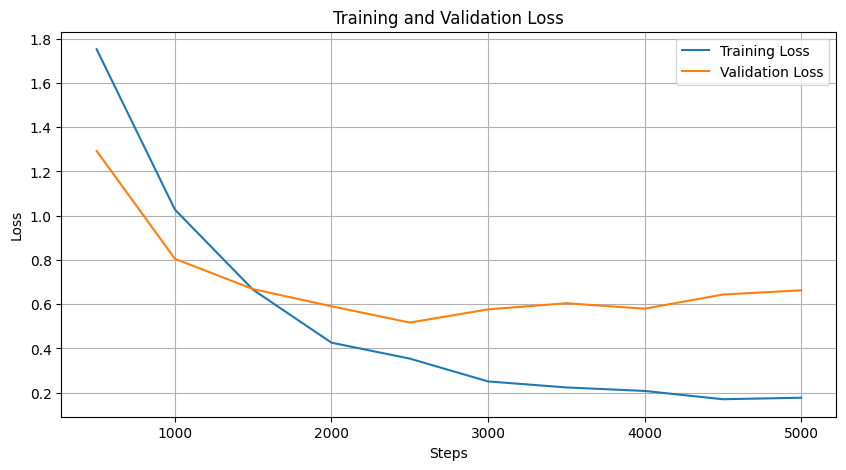

In [58]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

def plot_training_loss(log_dir):
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events' in f]
    if not event_files:
        raise ValueError("No event files found in log directory.")

    for event_file in event_files:
        losses = {'Step': [], 'Training Loss': [], 'Validation Loss': []}
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.tag == 'train/loss':
                    losses['Training Loss'].append(v.simple_value)
                    losses['Step'].append(e.step)
                elif v.tag == 'eval/loss':
                    losses['Validation Loss'].append(v.simple_value)

        if losses['Step']:
            df = pd.DataFrame(losses).set_index('Step')
            plt.figure(figsize=(10, 5))
            plt.plot(df['Training Loss'], label='Training Loss')
            plt.plot(df['Validation Loss'], label='Validation Loss')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# 로그 디렉토리를 지정하여 그래프 그리기
plot_training_loss('./logs')

In [59]:
test_dataset = encoded_dataset['test']

In [60]:
# 평가 데이터셋에 대한 예측 수행
predictions = trainer.predict(test_dataset)

In [61]:
# 예측된 레이블과 실제 레이블 추출
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# 각 클래스별 F1 스코어 계산
class_f1_scores = f1_score(true_labels, predicted_labels, average=None)

# 클래스별 F1 스코어 출력
for class_id, f1_score_value in enumerate(class_f1_scores):
    print(f"Class {class_id} F1 Score: {f1_score_value}")

Class 0 F1 Score: 0.6805429864253394
Class 1 F1 Score: 0.7932489451476793
Class 2 F1 Score: 0.9728471683475562
Class 3 F1 Score: 0.827972027972028
Class 4 F1 Score: 0.8465430016863406
Class 5 F1 Score: 0.8860544217687075
Class 6 F1 Score: 0.9119402985074626
Class 7 F1 Score: 0.9158453373768005
Class 8 F1 Score: 0.9086419753086419


In [62]:
trainer.save_model('/content/drive/MyDrive/models/CCIT_codebert_N:N(05-19_Juliet_plus)')

In [ ]:
import pandas as pd

df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/model train/MSR+julite+Div_final_test(2500cut).csv")

In [ ]:
df2.head(50)

,CWE ID,vul,lang,code,labels
0,CWE-119,1,c,"enum void func( const char *name, struct group...",0
1,CWE-119,1,c,"void func(struct sshbuf *m, struct ssh *ssh, i...",0
2,CWE-119,1,c,"void func(Jbig2HuffmanState *hs, int offset) {...",0
3,CWE-119,1,c,"void func(struct file *file, unsigned long add...",0
4,CWE-119,1,c,"void func(StyleDifference diff, const RenderSt...",0
5,CWE-119,1,c,long long Chapters::Atom::GetStartTimecode() c...,0
6,CWE-119,1,c,void func(struct atusb *atusb) { struct usb_d...,0
7,CWE-119,1,c,"void func(TGAContext *ctx, GError **err) { TGA...",0
8,CWE-119,1,c,void func( FT_Error error_code ) { FT_Face fa...,0
9,CWE-119,1,c,"void func( const ExtensionIdSet* extensions, i...",0


In [ ]:
df2 = df2[['vul', 'code']]

In [ ]:
import re

def preprocess2(df2, file_name):
    # 멀티 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df2['code'] = df2['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    # 매크로 정의 제거
    df2['code'] = df2['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df2['code'] = df2['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#endif'), "", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df2['code'] = df2['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df2['code'] = df2['code'].replace(re.compile(r'\n\s*\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return*.*?;'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return;'), "", regex=True)
    # void func 로 변경
    df2['code'] = df2['code'].replace(re.compile(r'\b([a-zA-Z_]\w*)\s+([a-zA-Z_]\w*)\s*\(([^)]*)\)\s*{'), r"void func(\3){", regex=True)
    # 데이터프레임을 CSV 파일로 저장
    df2.to_csv(file_name, index=False)
    return df2  # 수정된 데이터프레임 반환


def tokenized(examples):
  return tokenizer(examples['code'], pad_to_max_length=True, max_length=MAX_LEN,truncation=True, return_token_type_ids=True)

In [ ]:
preprocess2(df2,"preprocess2.csv")
dataset = load_dataset("csv",data_files="preprocess2.csv")['train']
encoded_dataset2 = dataset.map(tokenized,remove_columns=['code'],batched=True)
encoded_dataset2=encoded_dataset2.rename_column(original_column_name='vul',new_column_name='labels')

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
trainer.predict(encoded_dataset2, metric_key_prefix="eval")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PredictionOutput(predictions=array([[ 2.7014277 ,  0.06966877, -1.9814527 , ..., -3.1327283 ,
        -2.24265   ,  1.2172772 ],
       [ 3.2060697 ,  0.6515945 , -3.29584   , ..., -1.0153967 ,
        -1.9232178 ,  1.087447  ],
       [ 5.925215  ,  0.82576156, -3.4483445 , ..., -1.5838137 ,
        -1.1131264 , -0.09774696],
       ...,
       [ 1.7010915 , -2.021758  , -2.2548363 , ..., -1.6727322 ,
        -0.06559885,  1.0903865 ],
       [-0.41722494, -1.6855472 , -0.78323746, ..., -1.5395588 ,
        -0.89395726, -1.1896136 ],
       [ 0.9868477 , -1.3360825 , -1.8930078 , ..., -1.9976377 ,
        -1.7353909 ,  0.8746417 ]], dtype=float32), label_ids=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 